# 连接colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('drive/My Drive/Bilibili_Blackroom_Spider')

In [ ]:
os.chdir('Bilibili_Blackroom_Spider')

FileNotFoundError: ignored

In [1]:
!pwd

'pwd' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


# 导入库

In [2]:
import jieba
from tqdm import tqdm
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.engine.topology import Layer
from keras.layers import Embedding, Input, Dense, Conv2D, MaxPooling2D, Concatenate, Reshape, Dropout, Flatten, Lambda, LSTM, Bidirectional
from keras.models import Model
from keras import optimizers
import pdb
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from keras import backend as K
import re
import codecs
from keras import initializers, regularizers, constraints
import gc
import time
from gensim.models import Word2Vec
from keras import regularizers
import argparse
import pprint
import gensim
from glove import Glove
from glove import Corpus

EMBED_SIZE=200
MAX_LEN= 30 #样本最大长度为100，但是大部分长度都在0-40
EPOCHS = 40
BATCH_SIZE = 512
VAL_SPLIT = 0.1 #数据量很大，验证集可以不用20%
PUCNTS = [' ', '\'', '\"', '-', '.']

D:\Anaconda3\envs\tensorflow\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# 模型搭建

## 记录

In [5]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score, recall_score, precision_score

class Metrics(Callback):
    def __init__(self, test_data, test_label):
        super().__init__()
        self.test_data = test_data #记录测试集文本
        self.test_label = test_label #记录测试集标签
        
    def on_train_begin(self, logs={}):    #在训练前记录
        print("on train begin", len(self.test_data))    #输出测试集大小
        self.test_f1s = [] #记录测试集的F1参数
        self.test_recalls = []   #记录测试集的召回率
        self.test_precisions = []    #记录测试集的精确度

    def on_epoch_end(self, epoch, logs={}):   #在每一个epoch结束的时候
        print()
        print("on epoch end :", len(self.test_data))    #结束的时候输出此时测试集的大小
        data_num = len(self.test_data) ## 等于所有数据 / batchsize，所以所有数据需要能够整除

        test_pred = model.predict(self.test_data)    #测试集正确
        test_true = self.test_label
        test_pred_flat = np.zeros(data_num)    #测试集预测
        test_true_flat = np.zeros(data_num)    #测试集正确

        for data_count in range(data_num):
            test_pred_flat[data_count] = np.argmax(test_pred[data_count])
            test_true_flat[data_count] = np.argmax(test_true[data_count])
        print()
        
        _test_f1 = f1_score(test_true_flat, test_pred_flat, average='macro')
        _test_recall = recall_score(test_true_flat, test_pred_flat, average='macro')
        _test_precision = precision_score(test_true_flat, test_pred_flat, average='macro')
        self.test_f1s.append(_test_f1)
        self.test_recalls.append(_test_recall)
        self.test_precisions.append(_test_precision)
        print('— test_f1: %f — test_precision: %f — test_recall %f' %(_test_f1, _test_precision, _test_recall))
        print(' — test_f1:' ,_test_f1)
        return

## Attention

In [3]:
"""Attention Layer"""
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwar## Attentiongs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

## LSTM

In [4]:
## LSTM"LSTM models"
def model_lstm_attn(word_index, label_index, embedding_matrix):
    inp=Input(shape=(MAX_LEN,))
    x=Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix],input_length=MAX_LEN,trainable=False)(inp)
    x=Bidirectional(LSTM(128,return_sequences=True))(x)
    x=Bidirectional(LSTM(64,return_sequences=True))(x)
    x=Attention(MAX_LEN)(x)
    x=Dense(64,activation="relu")(x)
    x=Dense(len(labels_index), activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)
    model=Model(inputs=inp,outputs=x)
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    return model

## CNN

In [35]:
"CNN Model"
def model_cnn(word_index, label_index, embedding_matrix):
    filter_sizes=[1,2,3,5]
    num_filters=36

    inp=Input(shape=(MAX_LEN,))
    x=Embedding(len(word_index)+1,EMBED_SIZE,weights=[embedding_matrix])(inp)
    x=Reshape((MAX_LEN,EMBED_SIZE,1))(x)

    maxpool_pool=[]
    for i in range(len(filter_sizes)):
        conv=Conv2D(num_filters,kernel_size=(filter_sizes[i],EMBED_SIZE),
                    kernel_initializer='he_normal',activation='relu')(x)
        dropout=Dropout(0.1)(conv)
        maxpool_pool.append(MaxPooling2D(pool_size=(MAX_LEN-filter_sizes[i]+1,1))(dropout))
        

    z=Concatenate(axis=1)(maxpool_pool)
    z=Flatten()(z)
    z=Dropout(0.5)(z)

    outp=Dense(len(labels_index), activation='softmax')(z)

    model=Model(inputs=inp,outputs=outp)
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    return model

# 处理文本

In [16]:
def clean_text(x):
    x = x.strip()
    for punct in PUCNTS:
        x = x.replace(punct,'')
    return x

"让文本只保留汉字、英文和数字"
def is_chinese_alphabet_number(xchar):
    if (xchar >= u'\u4e00' and xchar <= u'\u9fa5') or (xchar >= u'\u0030' and xchar <= u'\u0039') or (xchar >= u'\u0041' and xchar <= u'\u005a') or (xchar >= u'\u0061' and xchar <= u'\u007a'):
        return True
    else:
        return False
"将汉字、英文和数字保留下来"
def keep_text(x):
    out_str=''
    for i in x:
        if is_chinese_alphabet_number(i):
            out_str = out_str+i
    return out_str

def seg_sentence(sentence,stopwords):
    "对句子进行分词和去除停用词"
    jieba.load_userdict("dataset/user_dict.txt")
    sentence_lower = sentence.lower()
    sentence_seged = jieba.cut(sentence_lower, cut_all=False)
    outstr=''
    for word in sentence_seged:
        if word not in stopwords:
                outstr+=word
                outstr+=" "
    return outstr

def build_vocab(sentences,verbose=True):
    "追踪训练词汇表，遍历所有文本对单词进行计数"
    vocab={}
    for sentence in tqdm(sentences,disable=(not verbose)):
        #print(sentence)
        for word in sentence.split():
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1

    return vocab

def texts_to_sequences(sentences,vocab,verbose=True):
    seq_sentences=[]
    #pdb.set_trace()
    unk_vec=np.random.random(embed_size)*0.5
    unk_vec=unk_vec-unk_vec.mean()
    for sentence in tqdm(sentences,disable=(not verbose)):
        seq_sentence=[]
        for word in sentence.split():
            seq_sentence.append(vocab.get(word,unk_vec))
        seq_sentences.append(seq_sentence)
    return seq_sentences

def load_and_prec():
    vocab_size = 100
    count = 0
    if not os.path.exists('dataset/pre_dataset.csv') :
        #文件读取
        dataset = pd.read_csv('dataset/dataset.csv')
        #创建停用词列表
        baidu_stopwords_file=open('dataset/baidu_stopwords.txt','r',encoding='utf-8')
        baidu_stopwords=baidu_stopwords_file.readlines()
        stopwords=[]
        for item in baidu_stopwords:
        stopwords.append(item.replace('\n',''))
#         stopwords = ['的', '呀', '这', '那', '就', '的话', '如果', '了', '建议', '说','是', '吧','我','你','在','这个','被','啊','和','吗','觉得','就是','应该','认为','很','感觉','可能','会','下面']
        #创建自定义词表
        dataset["content"]=dataset["content"].apply(lambda x: clean_text(x))
        dataset["content"]=dataset["content"].apply(lambda x: keep_text(x))
        dataset["content"]=dataset["content"].apply(lambda x: seg_sentence(x, stopwords))
        dataset.to_csv('dataset/pre_dataset.csv', index = False)
    else:
        dataset = pd.read_csv('dataset/pre_dataset.csv')
        for item in dataset['content']:
            if str(item) == 'nan':
                dataset['content'][count] = ''
            count += 1
    
    labelMap = {1: 0, 2: 1, 4: 2}
    labels = dataset['vote'].map(labelMap)
    texts = dataset['content'].values
    labels = labels.values
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index)) #Found 39468 unique tokens.词频词典
    
    word_num = [len(text) for text in sequences]
    plt.figure(figsize=(8,5))
    _ = plt.hist(word_num, bins = 100)
    plt.xlabel('word number')
    plt.ylabel('Freq')
    plt.show()

    data = pad_sequences(sequences, maxlen=MAX_LEN, padding = 'post') 
    labels = to_categorical(np.asarray(labels))
    print('Shape of data tensor:', data.shape) #(120000, 40)
    print('Shape of label tensor:', labels.shape) #(120000, 3)
    
    x_train_val, x_test, y_train_val, y_test = train_test_split(data, labels, test_size = VAL_SPLIT, random_state = 2021)
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = VAL_SPLIT, random_state = 2021)
    
    print("Train shape: ",x_train.shape)   # (97200, 40)
    print("Val shape: ",x_val.shape)   # (10800, 40)
    print("Test shape: ",x_test.shape) # (12000, 40)
    
    np.random.seed(2021)
    trn_idx=np.random.permutation(len(x_train))
    val_idx=np.random.permutation(len(x_val))
    print(x_train[0])
    x_train=x_train[trn_idx]
    x_val=x_val[val_idx]
    y_train=y_train[trn_idx]
    y_val=y_val[val_idx]
    print(x_train[0])
    return dataset, x_train, x_val, x_test, y_train, y_val, y_test, tokenizer

def input_embed():
    embeddings_index = {}
    with open('dataset/1000000-small.txt','r') as f:
        for i,line in tqdm(enumerate(f),disable=(not verbose)):
            if i == 0:
                continue
            values = line.split()
            word = values[0]
            codes = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = codes
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

def embed_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
            

In [ ]:
dataset, x_train, x_val, x_test, y_train, y_val, y_test, tokenizer = load_and_prec()
np.save("dataset/x_train.npy",x_train)
np.save("dataset/x_val.npy",x_val)
np.save("dataset/x_test.npy",x_test)
np.save("dataset/y_train.npy",y_train)
np.save("dataset/y_val.npy",y_val)
np.save("dataset/y_test.npy",y_test)
# saving 
with open('dataset/tokenizer_1.pickle', 'wb') as handle: 
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) 

# embeddings_index = input_embed()
# embedding_matrix = embed_matrix(tokenizer.word_index, embedding_index)
# np.save("dataset/embedding_matrix.npy",embedding_matrix)

In [3]:
x_train = np.load("dataset/x_train.npy")
x_val = np.load("dataset/x_val.npy")
x_test = np.load("dataset/x_test.npy")
y_train = np.load("dataset/y_train.npy")
y_val = np.load("dataset/y_val.npy")
y_test = np.load("dataset/y_test.npy")
with open('dataset/tokenizer.pickle', 'rb') as handle: 
  tokenizer = pickle.load(handle)
embedding_matrix = np.load('dataset/embedding_matrix.npy')
# x_train = np.load("dataset/w2v_x_train.npy")
# x_val = np.load("dataset/w2v_x_val.npy")
# x_test = np.load("dataset/w2v_x_test.npy")
# y_train = np.load("dataset/w2v_y_train.npy")
# y_val = np.load("dataset/w2v_y_val.npy")
# y_test = np.load("dataset/y_test.npy")
# with open('dataset/w2v_tokenizer.pickle', 'rb') as handle: 
#   tokenizer = pickle.load(handle)
# embedding_matrix = np.load('dataset/w2v_embedding_matrix.npy')
labels_index = [0, 1, 2]

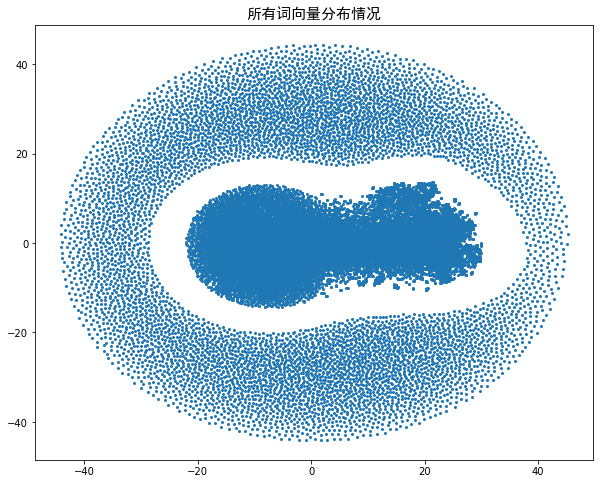

In [45]:
from sklearn .manifold import TSNE
tsne = TSNE(n_components = 2, random_state = 123)
word2vec_tsne = tsne.fit_transform(embedding_matrix)
plt.figure(figsize=(10,8))
plt.scatter(word2vec_tsne[:,0],word2vec_tsne[:,1],s=4)
plt.title('所有词向量分布情况',fontproperties='SimHei',size=15)
plt.show()

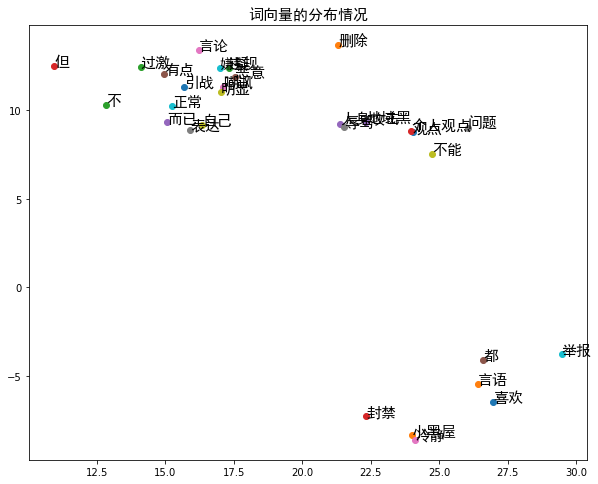

In [46]:
vis_word=['引战','删除','不','封禁','人身攻击','都','言论','问题','自己','举报',
         '观点','小黑屋','过激','但','而已','恶意','嘲讽','表达','明显','正常',
         '喜欢','言语','违规','个人观点','地域黑','有点','冷静','辱骂','不能','嫌疑',]
vis_word_index=[tokenizer.word_index[ii] for ii in vis_word ]
plt.figure(figsize=(10,8))
for ii,index in enumerate(vis_word_index):
    plt.scatter(word2vec_tsne[index,0],word2vec_tsne[index,1])
    plt.text(word2vec_tsne[index,0],word2vec_tsne[index,1],vis_word[ii],fontproperties='SimHei',size=15)
plt.title('词向量的分布情况',fontproperties='SimHei',size=15)
plt.show()    

# 词向量

## word2vec

In [26]:
def clean_text(x):
    x = x.strip()
    for punct in PUCNTS:
        x = x.replace(punct,'')
    return x

"让文本只保留汉字、英文和数字"
def is_chinese_alphabet_number(xchar):
    if (xchar >= u'\u4e00' and xchar <= u'\u9fa5') or (xchar >= u'\u0030' and xchar <= u'\u0039') or (xchar >= u'\u0041' and xchar <= u'\u005a') or (xchar >= u'\u0061' and xchar <= u'\u007a'):
        return True
    else:
        return False
"将汉字、英文和数字保留下来"
def keep_text(x):
    out_str=''
    for i in x:
        if is_chinese_alphabet_number(i):
            out_str = out_str+i
    return out_str

def seg_sentence(sentence,stopwords):
    "对句子进行分词和去除停用词"
    jieba.load_userdict("dataset/user_dict.txt")
    sentence_lower = sentence.lower()
    sentence_seged = jieba.cut(sentence_lower, cut_all=False)
    outstr=''
    for word in sentence_seged:
        if word not in stopwords:
                outstr+=word
                outstr+=" "
    return outstr

def build_vocab(sentences,verbose=True):
    "追踪训练词汇表，遍历所有文本对单词进行计数"
    vocab={}
    for sentence in tqdm(sentences,disable=(not verbose)):
        #print(sentence)
        for word in sentence.split():
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1

    return vocab

def texts_to_sequences(sentences,vocab,verbose=True):
    seq_sentences=[]
    #pdb.set_trace()
    unk_vec=np.random.random(embed_size)*0.5
    unk_vec=unk_vec-unk_vec.mean()
    for sentence in tqdm(sentences,disable=(not verbose)):
        seq_sentence=[]
        for word in sentence.split():
            seq_sentence.append(vocab.get(word,unk_vec))
        seq_sentences.append(seq_sentence)
    return seq_sentences

def w2v_load_and_prec():
    vocab_size = 100
    count = 0
    if not os.path.exists('dataset/pre_dataset.csv') :
        #文件读取
        dataset = pd.read_csv('dataset/dataset.csv')
        #创建停用词列表
#         baidu_stopwords_file=open('dataset/baidu_stopwords.txt','r',encoding='utf-8')
#         baidu_stopwords=baidu_stopwords_file.readlines()
#         stopwords=[]
#         for item in baidu_stopwords:
#         stopwords.append(item.replace('\n',''))
        stopwords = ['的', '呀', '这', '那', '就', '的话', '如果', '了', '么','你们','和','以及','建议', '说','是', '吧','我','你','之','一个','在','这个','被','啊','和','吗','觉得','就是','应该','认为','很','感觉','可能','会','下面']
        #创建自定义词表
        dataset["content"]=dataset["content"].apply(lambda x: clean_text(x))
        dataset["content"]=dataset["content"].apply(lambda x: keep_text(x))
        dataset["content"]=dataset["content"].apply(lambda x: seg_sentence(x, stopwords))
        dataset.to_csv('dataset/pre_dataset.csv', index = False)
    else:
        dataset = pd.read_csv('dataset/pre_dataset.csv')
        for item in dataset['content']:
            if str(item) == 'nan':
                dataset['content'][count] = ''
            count += 1
    
    labelMap = {1: 0, 2: 1, 4: 2}
    labels = dataset['vote'].map(labelMap)
    texts = dataset['content'].values
    labels = labels.values
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index)) #Found 39468 unique tokens.词频词典
    
    word_num = [len(text) for text in sequences]
    plt.figure(figsize=(8,5))
    _ = plt.hist(word_num, bins = 100)
    plt.xlabel('word number')
    plt.ylabel('Freq')
    plt.show()

    data = pad_sequences(sequences, maxlen=MAX_LEN, padding = 'post') 
    labels = to_categorical(np.asarray(labels))
    print('Shape of data tensor:', data.shape) #(120000, 40)
    print('Shape of label tensor:', labels.shape) #(120000, 3)
    
    x_train_val, x_test, y_train_val, y_test = train_test_split(data, labels, test_size = VAL_SPLIT, random_state = 2021)
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = VAL_SPLIT, random_state = 2021)
    
    print("Train shape: ",x_train.shape)   # (97200, 40)
    print("Val shape: ",x_val.shape)   # (10800, 40)
    print("Test shape: ",x_test.shape) # (12000, 40)
    
    np.random.seed(2021)
    trn_idx=np.random.permutation(len(x_train))
    val_idx=np.random.permutation(len(x_val))
    print(x_train[0])
    x_train=x_train[trn_idx]
    x_val=x_val[val_idx]
    y_train=y_train[trn_idx]
    y_val=y_val[val_idx]
    print(x_train[0])
    return dataset, x_train, x_val, x_test, y_train, y_val, y_test, tokenizer

def input_embed():
    embeddings_index = {}
    with open('dataset/1000000-small.txt','r') as f:
        for i,line in tqdm(enumerate(f),disable=(not verbose)):
            if i == 0:
                continue
            values = line.split()
            word = values[0]
            codes = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = codes
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

def embed_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
            

In [27]:
def word2vec_model(dataset, word_index, verbose=True):
    nb_words=len(word_index)
    print(nb_words)
    start=time.clock()
    all_data=dataset['content']
    file_name='dataset/word2vec.model'
    if not os.path.exists(file_name):
        model=Word2Vec([[word for word in sentence.split()] for sentence in all_data.values],
                       vector_size=EMBED_SIZE,window=5,epochs=10,workers=11,seed=2019,min_count=2)
        model.save(file_name)
    else:
        model=Word2Vec.load(file_name)
    print("add word2vec finished...")
    end=time.clock()
    print('Running time: %s Seconds' %(end-start))
     
#     max_features=20000
#     nb_words=min(max_features,len(vocab))
    embedding_word2vec_matrix=np.zeros((nb_words+1,EMBED_SIZE))
    for word,i in tqdm(word_index.items(),disable=(not verbose)):
#         if i>max_features:continue  #词频过多，代表不了含义
        embedding_vector=model.wv[word] if word in model.wv else None
        if embedding_vector is not None:
            embedding_word2vec_matrix[i]=embedding_vector
        else:
            unk_vec=np.random.random(EMBED_SIZE)*0.5
            unk_vec=unk_vec-unk_vec.mean()
#             unk_vec=0
            embedding_word2vec_matrix[i]=unk_vec
    del model;
    gc.collect()
          
    return embedding_word2vec_matrix

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Found 39391 unique tokens.


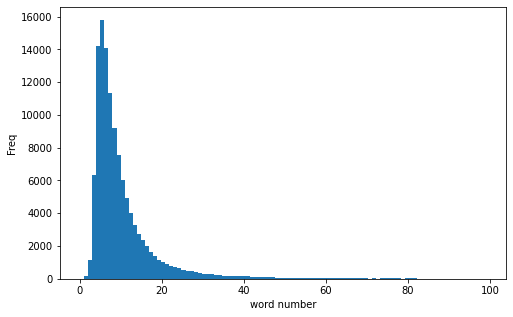

Shape of data tensor: (120000, 30)
Shape of label tensor: (120000, 3)
Train shape:  (97200, 30)
Val shape:  (10800, 30)
Test shape:  (12000, 30)
[  26   16  925    5  102 8590  257   74    6 2449  279    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[ 590   12  102 1491 1757 1624 1132    1    2  324   68  320   39  647
    3  140    3  374  434    0    0    0    0    0    0    0    0    0
    0    0]
39391


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
 46%|█████████████████████████████████                                       | 18088/39391 [00:00<00:00, 179561.17it/s]

add word2vec finished...
Running time: 0.8043886999994356 Seconds


100%|█████████████████████████████████████████████████████████████████████████| 39391/39391 [00:00<00:00, 73277.21it/s]


(39392, 200)


In [28]:
dataset, x_train, x_val, x_test, y_train, y_val, y_test, tokenizer= w2v_load_and_prec()
np.save("dataset/w2v_x_train.npy",x_train)
np.save("dataset/w2v_x_val.npy",x_val)
np.save("dataset/w2v_x_test.npy",x_test)
np.save("dataset/w2v_y_train.npy",y_train)
np.save("dataset/w2v_y_val.npy",y_val)
np.save("dataset/w2v_y_test.npy",y_test)
embedding_word2vec_matrix=word2vec_model(dataset,tokenizer.word_index)
with open('dataset/w2v_tokenizer.pickle', 'wb') as handle: 
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) 
print(embedding_word2vec_matrix.shape)  #(73915, 200)
np.save("dataset/w2v_embedding_matrix.npy",embedding_word2vec_matrix)

## GloVe

In [ ]:
def glove_model(dataset, word_index):
    corpus_model = Corpus()
    corpus_model.fit(dataset['content'], window=10)
    print('Dict size: %s' % len(corpus_model.dictionary))
    print('Collocations: %s' % corpus_model.matrix.nnz)
    glove_name='dataset/glove.model'
    corpus_name='dataset/corpus.model'
    if not os.path.exists(glove_name):
        #训练
        glove = Glove(no_components=100, learning_rate=0.05)
        glove.fit(corpus_model.matrix, epochs=10, no_threads=1, verbose=True)
        glove.add_dictionary(corpus_model.dictionary)
        glove.save('glove.model')
    else:
        glove = Glove.load(glove_name)
        
    if not os.path.exists(corpus_name):
        corpus_model.save(corpus_name)

    pdb.set_trace()
    


In [ ]:
if __name__ == '__main__':
    dataset, x_train, x_val, x_test, y_train, y_val, y_test, tokenizer= w2v_load_and_prec()
    glove_model(dataset, tokenizer.word_index)

# TextCNN

In [36]:
K.clear_session()
model = model_cnn(tokenizer.word_index, labels_index, embedding_matrix)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 200)      7878400     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 30, 200, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 1, 36)    7236        reshape[0][0]                    
_______________________________________________________________________________________

In [ ]:
myMetrics = Metrics(x_test, y_test)   #测试集在每个epoch的表现
history = model.fit(x_train, y_train, callbacks = [myMetrics], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

on train begin 12000
Epoch 1/40
760/760 [==============================] - ETA: 0s - loss: 1.1663 - accuracy: 0.6373
on epoch end : 12000

— test_f1: 0.774184 — test_precision: 0.774137 — test_recall 0.774659
 — test_f1: 0.7741837141268949
760/760 [==============================] - 144s 189ms/step - loss: 1.1663 - accuracy: 0.6373 - val_loss: 0.5589 - val_accuracy: 0.7740
Epoch 2/40
760/760 [==============================] - ETA: 0s - loss: 0.7067 - accuracy: 0.7354
on epoch end : 12000

— test_f1: 0.785693 — test_precision: 0.786564 — test_recall 0.786764
 — test_f1: 0.7856930962506802
760/760 [==============================] - 141s 186ms/step - loss: 0.7067 - accuracy: 0.7354 - val_loss: 0.5162 - val_accuracy: 0.7866
Epoch 3/40
760/760 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.7611
on epoch end : 12000

— test_f1: 0.791533 — test_precision: 0.792014 — test_recall 0.792349
 — test_f1: 0.7915332560030829
760/760 [==============================] - 144s 189m

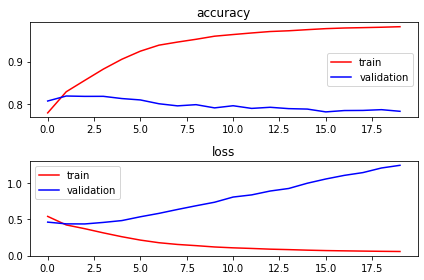

375/375 [==============================] - 2s 6ms/step - loss: 1.2224 - accuracy: 0.7872
Test loss: 1.222, accuracy: 0.787


In [65]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["accuracy"], color="r", label="train")
plt.plot(history.history["val_accuracy"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

# BiLSTM

In [8]:
K.clear_session()
Attn_BiLSTM = model_lstm_attn(tokenizer.word_index, labels_index, embedding_matrix)
Attn_BiLSTM.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 200)           7893800   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 256)           336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 128)           164352    
_________________________________________________________________
attention (Attention)        (None, 128)               158       
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [ ]:
Attn_BiLSTM.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
760/760 [==============================] - 229s 302ms/step - loss: 0.5538 - accuracy: 0.7656 - val_loss: 0.4939 - val_accuracy: 0.7941
Epoch 2/20
760/760 [==============================] - 227s 299ms/step - loss: 0.4691 - accuracy: 0.8027 - val_loss: 0.4588 - val_accuracy: 0.8075
Epoch 3/20
760/760 [==============================] - 216s 284ms/step - loss: 0.4405 - accuracy: 0.8142 - val_loss: 0.4448 - val_accuracy: 0.8129
Epoch 4/20
760/760 [==============================] - 162s 213ms/step - loss: 0.4209 - accuracy: 0.8225 - val_loss: 0.4348 - val_accuracy: 0.8216
Epoch 5/20
760/760 [==============================] - 165s 217ms/step - loss: 0.4044 - accuracy: 0.8293 - val_loss: 0.4334 - val_accuracy: 0.8172
Epoch 6/20
760/760 [==============================] - 164s 216ms/step - loss: 0.3899 - accuracy: 0.8356 - val_loss: 0.4168 - val_accuracy: 0.8273
Epoch 7/20
760/760 [==============================] - 166s 218ms/step - loss: 0.3749 - accuracy: 0.8436 - val_loss: 0.4358 -